# Classification and Regression of astronomical sources using multi-wavelength photometric data and machine learning

Chaka Mofokeng <br>
email: mofokeng.chk@gmail.com <br>
github: https://github.com/Mofokeng-C/

This is a tutorial that uses two machine learning algorithms: random forest and k-nearest neighbor classifiers. It uses corrected photometric magnitudes from SDSS together with corresponding WISE magnitudes, which are used to disentangle three different classes (stars, galaxies and quasars) and also estimate photometric redshifts by using colour magnitudes as features to learn.

This tutorial was developed using some of the code from sci-kit learn tutorials ([http://scikit-learn.org/stable/tutorial/index.html](http://url))

In [1]:
# Loading necessary modlules

import os 
import os.path as osp
import itertools
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import seaborn as sns
import timeit

from astropy.stats import bayesian_blocks
from scipy.stats import binned_statistic,norm, bayes_mvs
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde

#%matplotlib inline

In [2]:
def Preprocessing(filename, task='C', N=1000000):
    '''This function processes the data for a given task and returns the processed data.
    parameters:
    filename - path to the fits file
    task - process to be executed, default is Classification (c,C) another options is Regression (r,R)
    N - number of data point to use for data points
    
    returns:
    Arrays of data split into training and testng data depending on the task at hand.
    '''
    
    
    fp = pf.open(filename, memmap=True)
    data = fp[1].data
    fp.close()
    
    #Change the value of n to select only a subset of the data
    data = data[:N]


    #df = df.iloc[:n]
    ID = data['objID']
    u = data['dered_u']
    g = data['dered_g']
    r = data['dered_r']
    i = data['dered_i']
    z = data['dered_z']
    w1 = data['w1mpro']
    w2 = data['w2mpro']
   
    # use color as features – color is the difference of 
    # magnitudes between two different filter bands.
    # features: [u-g, g-r, r-i, i-z, z-w1, w1-w2]
    
    # feaures
    x = np.vstack([np.array(r), 
                   np.array(u) - np.array(g), 
                   np.array(g) - np.array(r), 
                   np.array(r) - np.array(i), 
                   np.array(i) - np.array(z), 
                   np.array(z) - np.array(w1), 
                   np.array(w1) - np.array(w2)]).T
    
    # keep track of all indices
    indices = np.arange(x.shape[0])
    
    # Regression
    if task == 'r' or task == 'R':
        # conditions on magnitude values
        cond_u = indices[np.logical_and(u>13.0,u<20.0)]
        cond_g = indices[np.logical_and(g>14.0,g<22.2)]
        cond_r = indices[np.logical_and(r>14.0,r<22.2)]
        cond_i = indices[np.logical_and(i>14.0,i<21.3)]
        cond_z = indices[np.logical_and(z>12.0,z<20.5)]
        
        # index of where all conditions are true
        cond_u_g = cond_u[np.in1d(cond_u,cond_g)]
        cond_u_g_r = cond_u_g[np.in1d(cond_u_g,cond_r)]
        cond_u_g_r_i = cond_u_g_r[np.in1d(cond_u_g_r,cond_i)]
        cond_u_g_r_i_z = cond_u_g_r_i[np.in1d(cond_u_g_r_i, cond_z)]
        
        # get values that satisfy the conditions
        class_0 = np.array([data['specclass'][i] for i in cond_u_g_r_i_z])
        class_1 = np.array([data['specsubclass'][i] for i in cond_u_g_r_i_z])
        redshift = np.array([data['zspec'][i] for i in cond_u_g_r_i_z])
        #warning = np.array([data['zspecwarning'][i] for i in cond_ug_r_i_z]) because all the values are equal to zeros, 
        # we do not need this value.
        
        # gather all rows
        x_data = np.zeros((len(cond_u_g_r_i_z),x.shape[1]))
        for i in range(len(cond_u_g_r_i_z)):
            x_data[i] = x[cond_u_g_r_i_z[i]]
        
        # keep track of all indices
        indices = np.arange(x_data.shape[0])
        
        # for regression we only use GALAXY and QSO data
        ix = np.where(class_0 != 'STAR')[0]
        i_gal = indices[class_0 == 'GALAXY'] # index of GALAXY class
        print('Number of galaxies: {}'.format(len(i_gal)))
        
        i_qso = indices[class_0 == 'QSO'] # index of QSO class
        print('\n\nNumber of quasars: {}'.format(len(i_qso)))
        
        y_z = redshift
        x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(x_data[ix], y_z[ix], ix, test_size=0.25) #splitting data into 75% and 25% train and test datasets, respectively
        return x_train, x_test, y_ztrain, y_ztest, i_train, i_test, i_gal, i_qso
    
    # Classification
    else:
        class_0 = data['specclass']
        class_1 = data['specsubclass']
        redshift = data['zspec']
        warning = data['zspecwarning']
        y = pd.factorize(class_0)[0]
        
        x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(x, y,indices, test_size=0.20) #splitting data into 80% and 20% train and test datasets, respectively
        return x_train, x_test, y_train, y_test, i_train, i_test

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pl.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')


In [4]:
def knn_classifier(cl, x_tr, x_t, y_tr, y_t):
    '''This function prints the performance metric of the kNN classifyer
    parameters:
    cl - the algorithm to perform classification
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    returns:
    y_ks - predicted labels from the test dataset
    proba - the probability of the predicted labels'''
    
    start_time = timeit.default_timer() 
    ks = cl
    ks.fit(x_train, y_train)  
    y_ks = ks.predict(x_test)
    elapsed = timeit.default_timer() - start_time
    proba = ks.predict_proba(x_test)
    #y_predict.append(y_ks)
    acu = acc(y_test, y_ks)
    
    print('Elapsed time for knn: {} seconds'.format(elapsed))
    print('Accuracy for kNN is: {}'.format(acu))
    print(metrics.classification_report(y_test, y_ks,target_names=['SFGs', 'STARS', 'QSOs'], digits=4))
    
    return y_ks, proba

In [5]:
def rf_classifier(cl, x_tr, x_t, y_tr, y_t):
    '''This function prints the performance metric of the RF classifier
    parameters:
    cl - the algorithm to perform classification
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    returns:
    y_ks - predicted labels from the test dataset
    proba - the probability of the predicted labels
    importance - ranking of the important features of the dataset'''
    
    start_time = timeit.default_timer() 
    ks = cl
    ks.fit(x_train, y_train)
    importance = ks.feature_importances_ 
    y_ks = ks.predict(x_test)
    elapsed = timeit.default_timer() - start_time
    proba = ks.predict_proba(x_test)
    acu = acc(y_test, y_ks)
    
    print('Elapsed time for rf: {} seconds'.format(elapsed))
    print('Accuracy for rf {}'.format(acu))
    print(metrics.classification_report(y_test, y_ks,target_names=['SFGs', 'STARS', 'QSOs'], digits=4))
    
    return y_ks, proba, importance

In [6]:
def photo_z_stats(zpredicted,ztrue):
    '''This function takes the arrays of the predicted and true redshift values
    and returns values used for evaluation of the photo-z regression process
            
    parameters:
    zpredicted - predicted redshift values from the algorithm
    ztrue - ground truth redshift values 
            
    returns:
    del_z_norm - normalized redshift estimation error
    del_z_mean - mean value of the normalized redshift estimation error (a.k.a bias)
    del_z_median - median value of the normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)
    del_z_MAD - median-absolute-deviation value of the normalized redshift estimation error
    del_z_NMAD - normalized-median-absolute-deviation (PS: less sensitive to outliers than the RMS, thus mostly preferred value of precision )
    '''
    # evaluation measures used for photo-z regression
    del_z_norm = (zpredicted-ztrue)/(1+ztrue) # normalized redshift estimation error

    del_z_mean = np.mean(del_z_norm)

    del_z_median = np.median(del_z_norm)

    del_z_RMS = np.std(del_z_norm)

    del_z_MAD = np.median(abs(del_z_norm - np.median(del_z_median)))

    del_z_NMAD = 1.4826*del_z_MAD 

    print('delta(z)_mean = {}; delta(z)_median = {}; sigma(delta(z)) = {}; nmad(delta(z)) = {}'.format(del_z_mean,del_z_median,del_z_RMS,del_z_NMAD))
            
    return del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD

In [7]:
def outliers_fractions(delta_z_norm,delta_z_rms):
    '''This function calculation a fraction of sources with large error for a given N.
    formula given as: normalized redshift estimation errors with values greater than 
    N times the standard deviation of the normalized redshift estimation errors.
    
    parameters:
    del_z_norm - normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)

    returns:
    N sigma values
    '''
    sig_1 = abs(delta_z_norm) > (1.*delta_z_rms)
    sigma_1 = (float(len(delta_z_norm[sig_1]))/len(delta_z_norm))*100.

    sig_2 = abs(delta_z_norm) > (2.*delta_z_rms)
    sigma_2 = (float(len(delta_z_norm[sig_2]))/len(delta_z_norm))*100.

    sig_3 = abs(delta_z_norm) > (3.*delta_z_rms)
    sigma_3 = (float(len(delta_z_norm[sig_3]))/len(delta_z_norm))*100.

    sig_4 = abs(delta_z_norm) > 0.15
    sigma_4 = (float(len(delta_z_norm[sig_4]))/len(delta_z_norm))*100.

    print('sigma1 = {}; sigma2 = {}; sigma3 = {}; sigma0.15 = {}'.format(sigma_1,sigma_2,sigma_3,sigma_4))
    
    return sigma_1,sigma_2,sigma_3,sigma_4

In [8]:
def regressor(rg,x_train, x_test, y_ztrain, y_ztest, i_train, i_test, i_gal, i_qso, name='', cl='', lim=[]):
    '''This function gives the plot of photo-z estimates of the given regressor
    parameters:
    rg - the algorithm to perform regression
    x_tr - training dataset
    x_t - test dataset
    y_ztr - photo-z training data
    y_zt - photo-z test data
    i_train - indices of training data 
    i_test - indices of test data
    i_gal - index of GALAXY specclass
    i_qso - index of QSO specclass
    name - name of the regressor
    cl - sources class ('GALAXY','QSO')
    lim - axis limits, default [0.0,0.5] ('GALAXY') ; [0.0,3.5] (QSO)
    
    returns:
    mean of the separation of the predicted and the true redshift.
    median of the separation of the predicted and the true redshift.
    rms of the separation of the predicted and the true redshift.
    nmad of the separation of the predicted and the true redshift.
    
    sigma (1*sigma, 2*sigma, 3*sigma and 4*sigma) of the separation of the predicted and the true redshift.
    plot of predicted and true redshift.
    '''
    
    
    if cl !='' and cl=='GALAXY':
        
        index_tr = i_gal[np.in1d(i_gal, i_train)]
        index_t = i_gal[np.in1d(i_gal, i_test)]
        
        x_tr = x_train[np.where(index_tr!=524809)[0]]
        y_tr = y_ztrain[np.where(index_tr!=524809)[0]]
        
        y_t = y_ztest[np.where(index_t!=131211)[0]]
        x_t = x_test[np.where(index_t!=131211)[0]]
        
        rg.fit(x_tr,y_tr)
        
        y_pred = rg.predict(x_t)
    
        ztest=y_t
        zpred=y_pred
        
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)
        
        axis_lim = np.array(lim)
        if axis_lim.size == 0:
            print('Invalid axis limits, using defaualt values')
            axi_lim = [0.0,0.5]
        else:
            axis_lim = np.array(lim)
            
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{\sigma_{NMAD} = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{\delta = %.4f}$"%del_z_RMS
        
        pl.figure(figsize=(11,11))
        pl.hlines(0.0,0.0,4.0,colors='k',linestyle='solid')
        pl.scatter(ztest, -del_z_norm, c='b', lw=0, s=4)
        
        pl.hlines(0.15,0.0,4.0,colors='r',linestyle='dashed')
        pl.hlines(-0.15,0.0,4.0,colors='r',linestyle='dashed')

        pl.xlim([0.0,4.0])
        pl.ylim(axis_lim)
        pl.title('Photo-z: ' + name + '- SFG')
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        #pl.ylabel(r'$\mathrm{z_{phot} - }$', fontsize=14)
        pl.ylabel(r'$\mathbf{({z_{spec} - z_{phot})/(1+z_{spec}})}$', fontsize=14)
        pl.text(3.0, -1.5, str_nmad,fontsize=14)
        pl.text(3.0, -1.6, str_del,fontsize=14)
        
    else:
        # because the photo-z data contains nan values
        # we remove all the rows with such values in the data for regression.
        # cond_train = np.isin(i_train, i_qso)
        # cond_test = np.isin(i_test, i_qso)
        
        index_tr = i_qso[np.in1d(i_qso, i_train)] # indices of qso in training set
        index_t = i_qso[np.in1d(i_qso, i_test)] # indices of qso in testing set
        
        x_tr = x_train[np.where(index_tr!=524809)[0]] # skip an error at this index
        y_tr = y_ztrain[np.where(index_tr!=524809)[0]] # skip an error at this index
        
        y_t = y_ztest[np.where(index_t!=131211)[0]] # skip an error at this index
        x_t = x_test[np.where(index_t!=131211)[0]] # skip an error at this index
        
        # fit training data
        rg.fit(x_tr,y_tr)
        
        # predict labels of the test data
        y_pred = rg.predict(x_t)
    
        ztest=y_t
        zpred=y_pred
        
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)

        axis_lim = np.array(lim)
        if axis_lim.size == 0:
            print('Invalid axis limits, using defaualt values')
            axi_lim = [0.0,3.5]
        else:
            axis_lim = np.array(lim)
            
        
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{\sigma_{NMAD} = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{\delta = %.4f}$"%del_z_RMS
        
        pl.figure(figsize=(11,11))
        pl.hlines(0.0,0.0,4.0,colors='k',linestyle='solid')
        pl.scatter(ztest, -del_z_norm, c='b', lw=0, s=4)
        
        pl.hlines(0.15,0.0,4.0,colors='r',linestyle='dashed')
        pl.hlines(-0.15,0.0,4.0,colors='r',linestyle='dashed')

        pl.xlim([0.0,4.0])
        pl.ylim(axis_lim)
        pl.title('Photo-z: ' + name + '- QSO')
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        #pl.ylabel(r'$\mathrm{z_{phot} - }$', fontsize=14)
        pl.ylabel(r'$\mathbf{({z_{spec} - z_{phot})/(1+z_{spec}})}$', fontsize=14)
        pl.text(3.0, -1.5, str_nmad,fontsize=14)
        pl.text(3.0, -1.6, str_del,fontsize=14)
        #pl.legend()
        #pl.colorbar()
        #pl.savefig(name+'_regression.png')

In [9]:
def roc_curve(y_t, proba, name=''):
    '''This function returns the roc curve plot 
    paramters:
    y_t - test dataset labels
    proba - proabaility of the predicted label by the classifier
    name - name of the classifyer
    
    returns a plot of the roc curve of the data'''
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(proba[0])):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test, proba[:,i], pos_label=i)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    #Plot the roc_curve
    pl.figure(figsize=(11,11))
    
    pl.title(name)
    pl.xlabel('false positive rate')
    pl.ylabel('true positive rate')
    
    pl.plot(fpr[0],tpr[0], label='ROC curve for GALAXIES (area = %0.2f)' %roc_auc[0])
    pl.plot(fpr[1],tpr[1], label='ROC curve for STARS (area = %0.2f)' %roc_auc[1])
    pl.plot(fpr[2],tpr[2], label='ROC curve for QSOs (area = %0.2f)' %roc_auc[2])
    pl.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    pl.grid(True)
    pl.legend(loc=4)
    

In [10]:
def feature_importance(cl,importance,x_tr, x_t, y_tr, y_t,thresh=0.15):
    '''This function Create a selector object that will use 
    the random forest classifier to identify 
    features that have an importance of more than the given
    threshold.
    parameters:
    cl - the algorithm to perform classification
    importance - ranking of the important features of the dataset
    thresh - feature importance threshold, default thresh=0.15
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    returns:
    plot of feature importance.
    '''
    
    sfm = SelectFromModel(cl, threshold=thresh)
    
    # Train the selector
    sfm.fit(x_tr, y_tr)

    # Transform the data to create a new dataset containing only the most important features
    # Note: We have to apply the transform to both the training X and test X data.
    x_important_train = sfm.transform(x_tr)
    x_important_test = sfm.transform(x_t)

    # Create a new random forest classifier for the most important features
    rs_important = RandomForestClassifier(30)

    # Train the new classifier on the new dataset containing the most important features
    rs_important.fit(x_important_train, y_tr)
    y_rs_important = rs_important.predict(x_important_test)
    proba_ = rs_important.predict_proba(x_important_test)
    acu_important=acc(y_t, y_rs_important)
    
    print ('\n\nAccuracy for RF (feature selection): ' + repr(acu_important))# printing out your results
    print (metrics.classification_report(y_t, y_rs_important,target_names=['SFGs', 'STARS', 'QSOs'], digits=4))



    std = np.std([cl.feature_importances_ for tree in cl.estimators_],axis=0)
    
    t_label = ['r','u-g' , 'g-r', 'r-i', 'i-z', 'z-w1', 'w1-w2']
    labels = []
    
    indices = np.argsort(importance)[::-1]
    for f in range(len(t_label)):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))
        labels.append(t_label[indices[f]])
    
    # Plot the feature importances of the forest
    
    #i = np.arange(x.shape[1])
    #labels = t_label[indices[i]]
    
    pl.figure(figsize=(11,11))
    pl.title("Feature importances")
    pl.bar(range(len(labels)), importance[indices],
           color="r", yerr=std[indices], align="center")
    pl.xticks(range(len(labels)),labels, rotation = 45 )
    pl.xlim([-1, len(labels)])
    #pl.savefig('rf_feature_importance.png')

### Load data from the catalogue

In [11]:
#Loading data from the catalogue
#in this case the file is in the same directory as the jupyter notebook
file = osp.join(".","sdss_all_small_dr16_allwise_red.fits.gz") #to specify your own "path/to/file" 
                                                               #change the first parameter (".")

fp = pf.open(file, memmap=True)
data = fp[1].data
fp.close

<bound method HDUList.close of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fde2185dbd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fde2188afd0>]>

In [12]:
N_all = len(data) # all rows from the catalogue (= 3840668)

### visualizing features of the data 

In [13]:
#Change the value of n to select only a subset of the data
N = 5000#len(data)
data = data[:N]


ID = data['objID']
u = data['dered_u']
g = data['dered_g']
r = data['dered_r']
i = data['dered_i']
z = data['dered_z']
w1 = data['w1mpro']
w2 = data['w2mpro']
   
    
#Splitting photometric data into test and train data
x = np.vstack([np.array(r), 
               np.array(u) - np.array(g), 
               np.array(g) - np.array(r), 
               np.array(r) - np.array(i), 
               np.array(i) - np.array(z), 
               np.array(z) - np.array(w1), 
               np.array(w1) - np.array(w2)]).T

In [14]:
data['specclass']

chararray(['GALAXY', 'QSO', 'GALAXY', ..., 'STAR', 'GALAXY', 'GALAXY'],
          dtype='<U32')

In [15]:
data['specsubclass']

chararray(['', 'BROADLINE', '', ..., 'K5 (G_19-24)', 'STARBURST',
           'STARBURST'], dtype='<U32')

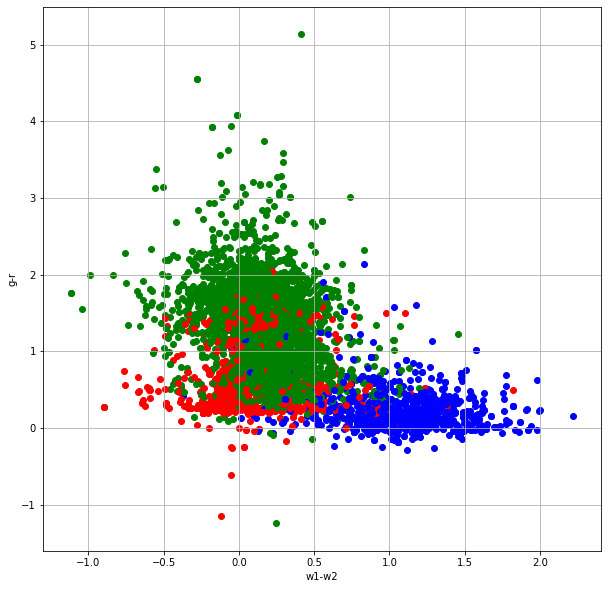

In [16]:
# create a figure and axis
fig, ax = pl.subplots(figsize=(10,10))
labels = ["r","u-g","g-r","r-i","i-z","z-w1","w1-w2"]
nlabels = len(labels)

# select two random features
ilabels = np.random.choice(nlabels,2)

# defining specific colours for each class
colors = {'STAR':'r', 'GALAXY':'g', 'QSO':'b'}

# plot each data point
#naxis = len(x.shape[1])
for i in range(len(x[:,0])):
    ax.scatter(x[:,ilabels[0]][i], x[:,ilabels[1]][i],color=colors[data['specclass'][i]])
# set a title and labels
#ax.set_title('Iris Dataset')
ax.set_xlabel(labels[ilabels[0]])
ax.set_ylabel(labels[ilabels[1]])
ax.grid()
pl.gca()

# Classification

Classification is a process of grouping objects according to
shared properties and is applied to help understand the origin and evolution of the
objects under consideration. It can be performed using different observed properties of objects, properties like colour, morphology or size. For instance, in the tutorrial to follow, classification is performed differentiate between three classes of [astronomical sources](https://en.wikipedia.org/wiki/Astronomical_object) (stars, galaxies, quasars) using colour properties derived from photometric magnitudes. </br>

### preprocessing the data for classification

In [17]:
# preprocess the data
x_train, x_test, y_train, y_test, i_train, i_test = Preprocessing(file,'C',N=N_all)

### performing classification

In [18]:
#kNearestNeighbor
# using 10 nearest neighbors
ks = KNeighborsClassifier(n_neighbors=10)

y_knn, proba_knn = knn_classifier(ks, x_train, x_test, y_train, y_test)

Elapsed time for knn: 224.13699851399997 seconds
Accuracy for kNN is: 0.972300405918759
              precision    recall  f1-score   support

        SFGs     0.9753    0.9865    0.9809    512462
       STARS     0.9667    0.9547    0.9607    131529
        QSOs     0.9654    0.9324    0.9486    124143

    accuracy                         0.9723    768134
   macro avg     0.9691    0.9579    0.9634    768134
weighted avg     0.9722    0.9723    0.9722    768134



In [19]:
# RandomForest
# using 30 number of decision trees
rf = RandomForestClassifier(30)

y_rf, proba_rf, importance =rf_classifier(rf, x_train, x_test, y_train, y_test)

Elapsed time for rf: 927.9708169209999 seconds
Accuracy for rf 0.978197814443834
              precision    recall  f1-score   support

        SFGs     0.9804    0.9895    0.9849    512462
       STARS     0.9706    0.9609    0.9657    131529
        QSOs     0.9770    0.9498    0.9632    124143

    accuracy                         0.9782    768134
   macro avg     0.9760    0.9667    0.9713    768134
weighted avg     0.9782    0.9782    0.9781    768134



### evaluating the performance of the classifiers

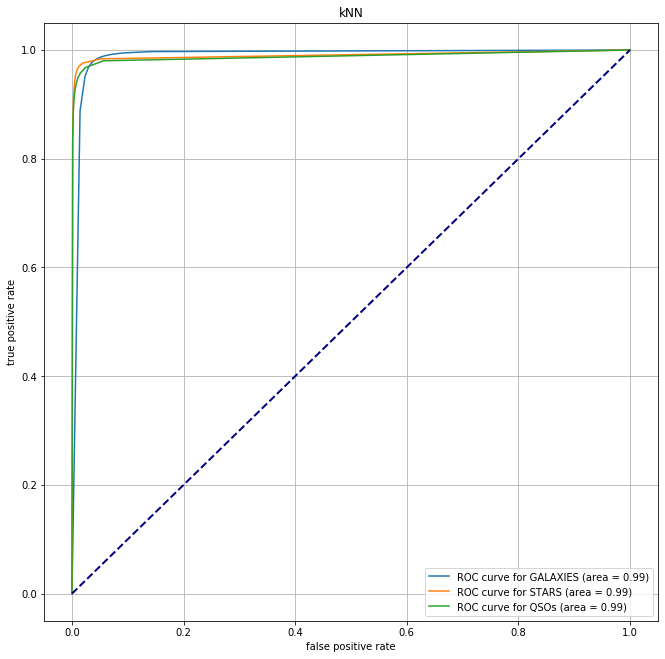

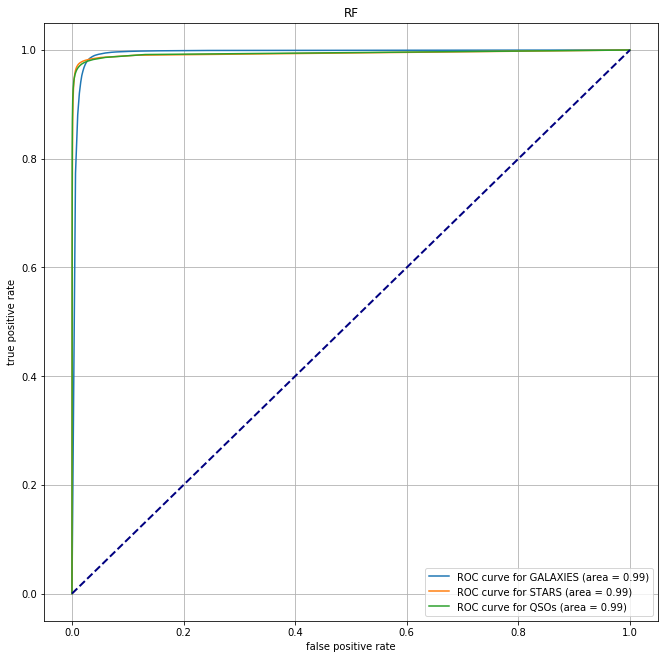

In [20]:
# ROC curve
roc_curve(y_test, proba_knn, 'kNN') #kNN roc_curve

roc_curve(y_test, proba_rf, 'RF') #RF roc_curve

Confusion matrix, without normalization
[[505530   3120   3812]
 [  5618 125573    338]
 [  7189   1200 115754]]
Normalized confusion matrix
[[0.99 0.01 0.01]
 [0.04 0.95 0.  ]
 [0.06 0.01 0.93]]


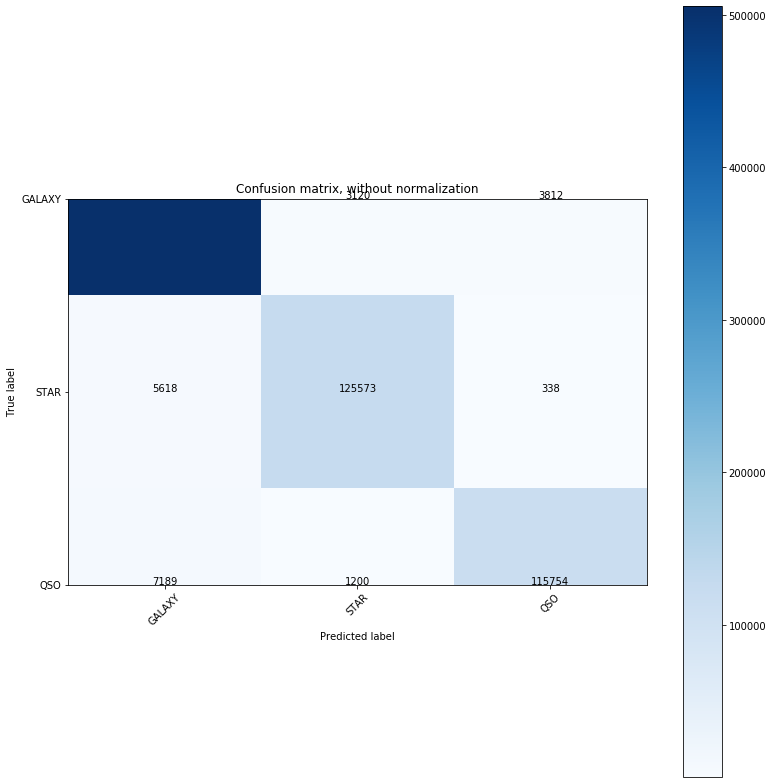

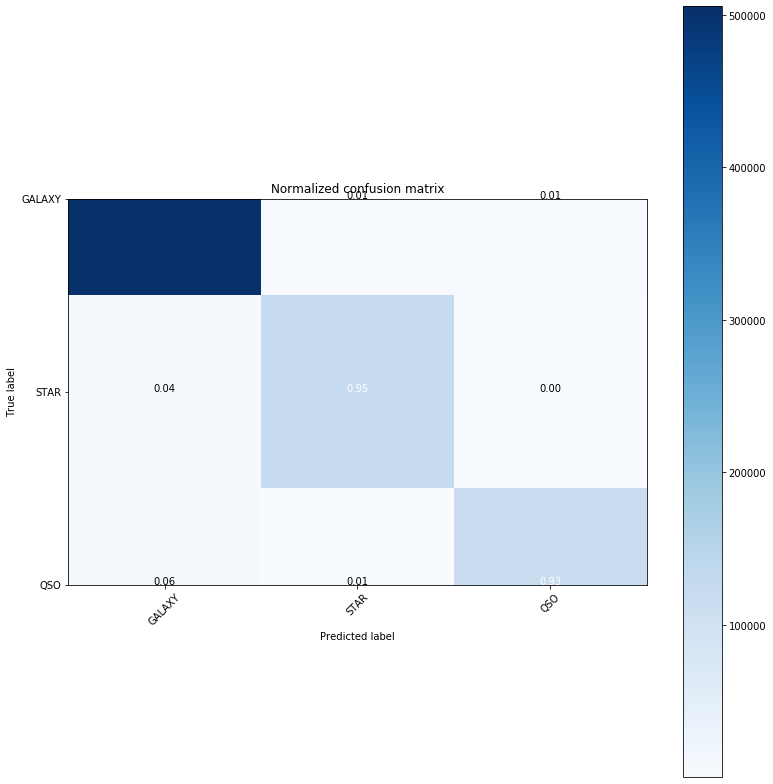

In [21]:
# Compute confusion matrix for kNN classifier
cnf_matrix = metrics.confusion_matrix(y_test, y_knn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix`
pl.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix, classes=['GALAXY','STAR','QSO'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix,classes=['GALAXY','STAR','QSO'], normalize=True,
                      title='Normalized confusion matrix')

Confusion matrix, without normalization
[[507092   2874   2496]
 [  4868 126387    274]
 [  5279    956 117908]]
Normalized confusion matrix
[[0.99 0.01 0.  ]
 [0.04 0.96 0.  ]
 [0.04 0.01 0.95]]


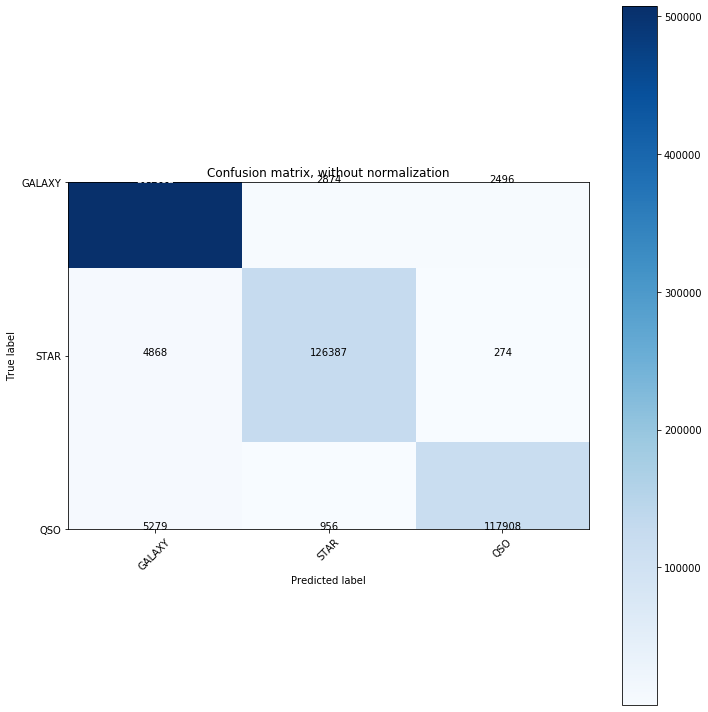

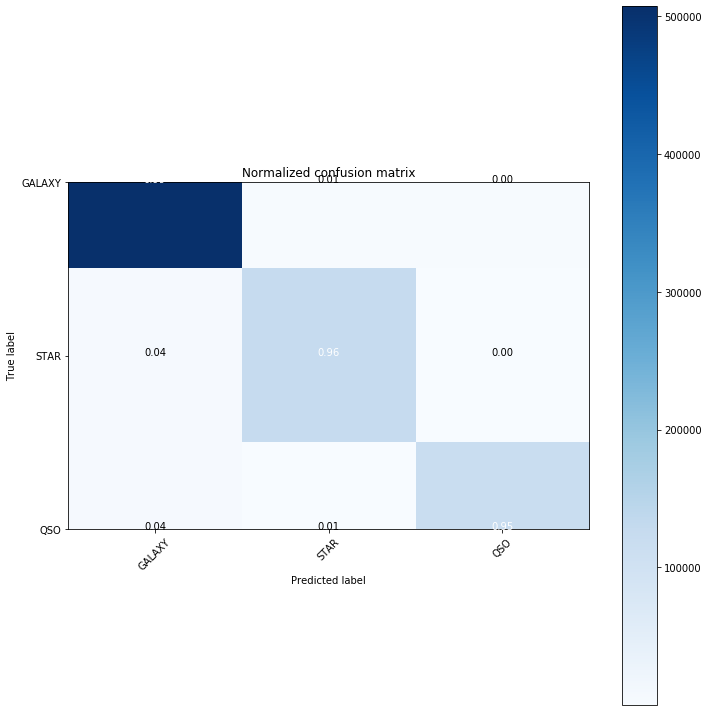

In [22]:
# Compute confusion matrix for Rf classifier
cnf_matrix = metrics.confusion_matrix(y_test, y_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix`
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['GALAXY','STAR','QSO'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix,classes=['GALAXY','STAR','QSO'], normalize=True,
                      title='Normalized confusion matrix')

### feature importance



Accuracy for RF (feature selection): 0.9535966380865839
              precision    recall  f1-score   support

        SFGs     0.9622    0.9728    0.9675    512462
       STARS     0.9482    0.9465    0.9473    131529
        QSOs     0.9221    0.8818    0.9015    124143

    accuracy                         0.9536    768134
   macro avg     0.9441    0.9337    0.9388    768134
weighted avg     0.9533    0.9536    0.9534    768134

1. feature 6 (0.242761)
2. feature 3 (0.168676)
3. feature 2 (0.162675)
4. feature 5 (0.143606)
5. feature 4 (0.133078)
6. feature 1 (0.090603)
7. feature 0 (0.058601)


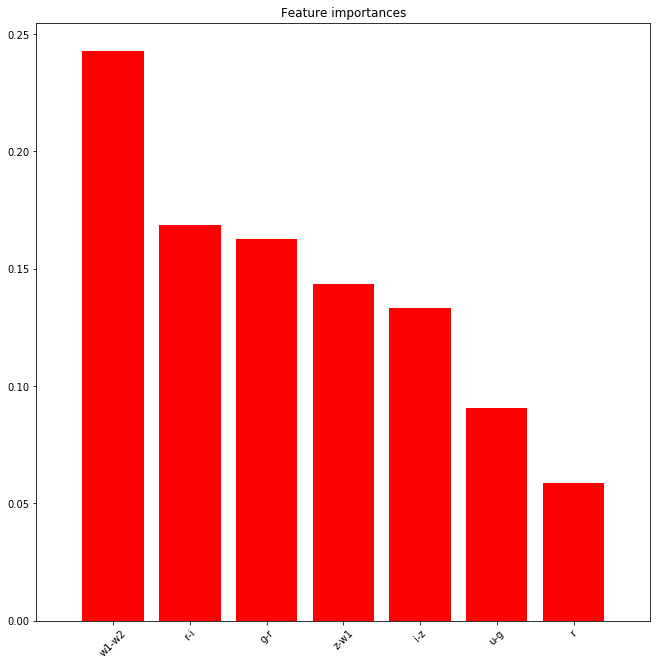

In [23]:
feature_importance(rf,importance,x_train, x_test, y_train, y_test)

# Regression

Regression is defined as a measure of the relation between the values one variable (e.g. output) and corresponding values of other variable(s). In astronomy, regression is popular for mapping the relation between the redshift and the measured properties of the given astronomical source. For instance, in the tutorial to follow, the focus is on the relation between the photometric and the spectroscopic redshifts of the two classes: starforming galaxies (SFGs) and quasars (QSOs).

[Photometric redshift](https://en.wikipedia.org/wiki/Photometric_redshift) (photo-z) is a quantity measured by passing light from a given source through a number of standard broad band filters, the intensity through these different filters is then used to determine the redshift. On the other hand, spectroscopic redshift (spec-z) is measured using the spectral lines observed from the source's spectrum and the measuring the shift in frequency or wavelength of the observed emission/absorption line.</br>

Due to the fact that spectroscopic measurements can be expensive and a high wavelength resolution spectrograph is required to be able to accurately identify the lines. Also, spectroscopic measurements are limited by the faint sources. One of the main advantages of the photometric measurements is that the broad band flux measurements of all identified sources from imaging surveys can be used to estimate the photo-z of the given source. As a result, because of the complementary nature betweem photo- and spec-z, astronomers usually study large samples of photo-z estimates available, allowing for statistical anyalysis to be carried out.

In [24]:
x_train, x_test, y_ztrain, y_ztest, i_train, i_test, i_gal, i_qso = Preprocessing(file, 'r', N=N_all)

Number of galaxies: 595336


Number of quasars: 180447


#### SFGs

delta(z)_mean = 0.0035584326833486557; delta(z)_median = 0.0001332246174570173; sigma(delta(z)) = 0.06660623848438263; nmad(delta(z)) = 0.016981207666173576
sigma1 = 4.024929985157525; sigma2 = 1.7139364795798437; sigma3 = 1.1612053970194163; sigma0.15 = 1.5292450485906364


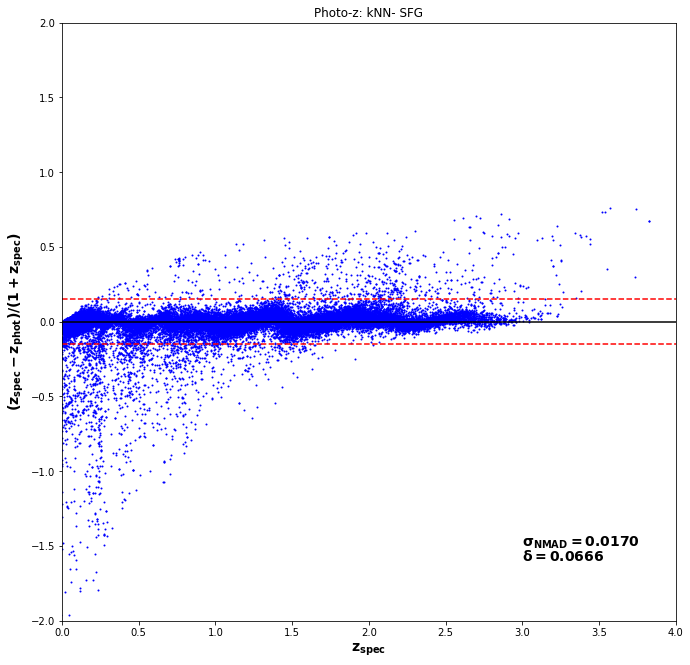

In [25]:
# kNearestRegressor
# using 10 nearest neighbors 
kg = KNeighborsRegressor(n_neighbors=10, weights='uniform')
regressor(kg,x_train, x_test, y_ztrain, y_ztest, i_train, i_test, i_gal, i_qso, 'kNN', 'GALAXY', [-2.0,2.0])

delta(z)_mean = 0.004206402906995685; delta(z)_median = 0.00017266980324749743; sigma(delta(z)) = 0.06431566144318882; nmad(delta(z)) = 0.013372345116193379
sigma1 = 4.100149767960402; sigma2 = 1.850943941113656; sigma3 = 1.1820251583309267; sigma0.15 = 1.566854939992075


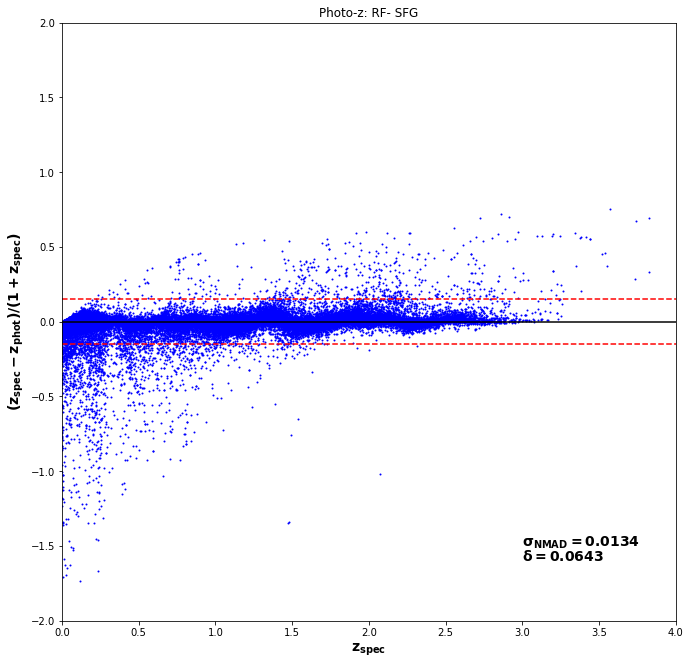

In [26]:
# RandomForestRegressor
# using 30 number of decision trees
rfg = RandomForestRegressor(30)
regressor(rfg,x_train, x_test, y_ztrain, y_ztest, i_train, i_test, i_gal, i_qso, 'RF', 'GALAXY', [-2.0,2.0])

#### QSOs

delta(z)_mean = 0.004048895090818405; delta(z)_median = 0.000214494823012501; sigma(delta(z)) = 0.06723667681217194; nmad(delta(z)) = 0.018233772914484143
sigma1 = 4.64383227152656; sigma2 = 1.9290106328664343; sigma3 = 1.2830473484428067; sigma0.15 = 1.6826122666429886


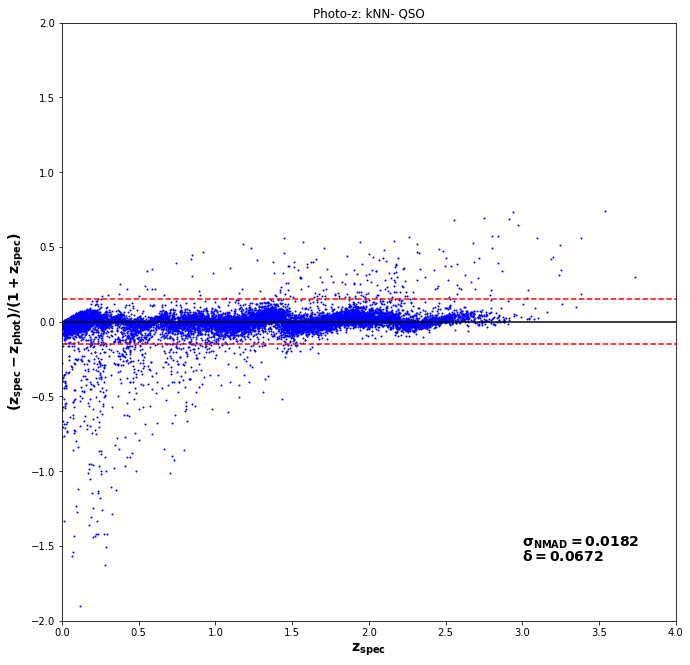

In [27]:
# kNearestRegressor
# using 10 nearest neighbors 
kg = KNeighborsRegressor(n_neighbors=10, weights='uniform')
regressor(kg,x_train, x_test, y_ztrain, y_ztest, i_train, i_test, i_gal, i_qso, 'kNN', '', [-2.0,2.0])

delta(z)_mean = 0.004797729124833535; delta(z)_median = 0.00029212732732154865; sigma(delta(z)) = 0.06909610864266544; nmad(delta(z)) = 0.014986901612508704
sigma1 = 4.552820262380964; sigma2 = 2.084396989944283; sigma3 = 1.3518613065772824; sigma0.15 = 1.9134719971586494


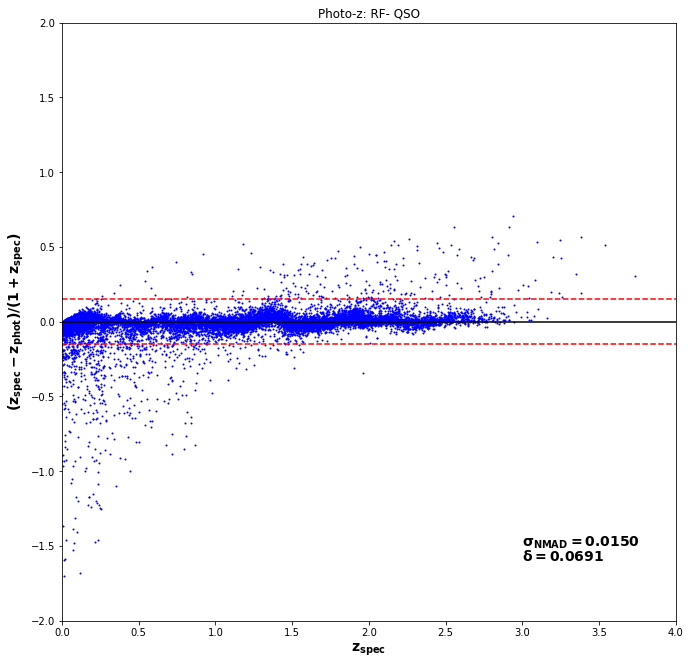

In [28]:
# RandomForestRegressor
# using 30 number of decision trees
rfg = RandomForestRegressor(30)
regressor(rfg,x_train, x_test, y_ztrain, y_ztest, i_train, i_test, i_gal, i_qso, 'RF', '', [-2.0,2.0])